Import

In [3]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import GridSearchCV

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class MultiLayerBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1=nn.Sequential(
        nn.Linear(352,352),
        nn.ReLU(),
        nn.Linear(352,352),
        nn.ReLU())    
        self.layer2=nn.Sequential(
        nn.Linear(352,352),
        nn.ReLU(),
        nn.Linear(352,1),
        nn.Sigmoid())    
    
    def forward(self,x):
        x=self.layer1(x)
        x=self.layer2(x)
        return x

<h2>Read processed dataframe<h2>

In [112]:
pathway=pd.read_csv("ppipathway1.3.csv",index_col=0)  #read dataframe
x = pathway[pathway.columns.difference(['phenotype'])]   
y = pathway['phenotype']                           
x_overtrain, x_overtest, y_overtrain, y_overtest= train_test_split(x_overscaled, y_resampled, 
                                                            test_size = 0.2, random_state = 123)  #split test&train
y_train = torch.tensor(y_overtrain.values)
x_train = torch.tensor(x_overtrain)
x_test  = torch.tensor(x_overtest)
y_test  = torch.tensor(y_overtest.values)
print(y_train)
print(x_train)

tensor([1., 0., 1.,  ..., 1., 0., 1.], dtype=torch.float64)
tensor([[-0.1963,  0.0541, -0.1784,  ..., -0.2016, -0.3706, -0.4380],
        [-0.2825, -0.1492, -0.1784,  ..., -0.4168, -0.4287, -0.4380],
        [ 6.4046,  0.4609,  8.5275,  ..., -0.3553, -0.2980, -0.3331],
        ...,
        [-0.1963, -0.2170, -0.1784,  ..., -0.3246, -0.3633, -0.3855],
        [-0.2825, -0.2170, -0.1784,  ..., -0.4168, -0.4287, -0.4336],
        [-0.2825, -0.2170, -0.1784,  ..., -0.4168, -0.4287, -0.4380]],
       dtype=torch.float64)


<h1>putting dataframe into tensor <h1>

In [192]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
ada = ADASYN()
x = pathway[pathway.columns.difference(['phenotype'])]
y = pathway['phenotype']
X_resampled, y_resampled = ada.fit_resample(x, y)
scaler = StandardScaler()
x_overscaled = scaler.fit_transform(X_resampled)
x_overtrain, x_overtest, y_overtrain, y_overtest= train_test_split(x_overscaled, y_resampled, 
                                                            test_size = 0.3, random_state = 123)
y_train = torch.tensor(y_overtrain.values)
x_train = torch.tensor(x_overtrain)
x_test  = torch.tensor(x_overtest)
y_test  = torch.tensor(y_overtest.values)
y_train.unsqueeze_(dim=1)




tensor([[0.],
        [1.],
        [0.],
        ...,
        [1.],
        [0.],
        [1.]], dtype=torch.float64)

<h2>Running Perceptron Classifier<h2>

In [270]:
model=MultiLayerBinaryClassifier()
optimizer=optim.SGD(model.parameters(),lr=1e-04)

In [273]:

nb_epochs=100000
device ="cuda" if torch.cuda.is_available() else "cpu"
criterion=torch.nn.BCELoss().to(device)
for epoch in range(nb_epochs+1):
    hypothesis=model(x_train.float())
    optimizer.zero_grad()
 
    cost=criterion(hypothesis,y_train.float())        
    cost.backward()
    optimizer.step()
   
    if epoch%500==0:
        hypothesis2=model(x_test.float())
        prediction = hypothesis2>= torch.FloatTensor([0.5])
        correct_prediction =prediction.float() ==y_test
        accuracy=correct_prediction.sum().item()/len(correct_prediction)
        print('Epoch{:4d} , Accurracty{:2f}'.format(epoch,accuracy))

Epoch   0 , Accurracty0.490119
Epoch 500 , Accurracty0.492211
Epoch1000 , Accurracty0.491281
Epoch1500 , Accurracty0.490816
Epoch2000 , Accurracty0.491514
Epoch2500 , Accurracty0.491979
Epoch3000 , Accurracty0.497791
Epoch3500 , Accurracty0.558010
Epoch4000 , Accurracty0.569170
Epoch4500 , Accurracty0.572890
Epoch5000 , Accurracty0.578703
Epoch5500 , Accurracty0.583818
Epoch6000 , Accurracty0.590328
Epoch6500 , Accurracty0.591025
Epoch7000 , Accurracty0.591025
Epoch7500 , Accurracty0.593583
Epoch8000 , Accurracty0.596373
Epoch8500 , Accurracty0.597535
Epoch9000 , Accurracty0.597535
Epoch9500 , Accurracty0.599163
Epoch10000 , Accurracty0.599163
Epoch10500 , Accurracty0.600558
Epoch11000 , Accurracty0.601488
Epoch11500 , Accurracty0.604511
Epoch12000 , Accurracty0.605906
Epoch12500 , Accurracty0.606836
Epoch13000 , Accurracty0.607998
Epoch13500 , Accurracty0.610091
Epoch14000 , Accurracty0.609858
Epoch14500 , Accurracty0.611021
Epoch15000 , Accurracty0.611951
Epoch15500 , Accurracty0.613

KeyboardInterrupt: 

In [269]:
optimizer2=optim.SGD(model2.parameters(),lr=1e-4)
nb_epochs=20000000
for epoch in range(nb_epochs+1):
    hypothesis=model2(x_train.float())
    cost=F.binary_cross_entropy(hypothesis,y_train.float())        
    optimizer2.zero_grad()
    cost.backward()
    optimizer2.step()
    prediction =hypothesis>= torch.FloatTensor([0.5])
    correct_prediction =prediction.float() ==y_train
    accuracy=correct_prediction.sum().item()/len(correct_prediction)
    if epoch%10000==0:
        print('Epoch{:4d} , cost{:2f} ,Accurracy{:2f}'.format(epoch,cost,accuracy))

Epoch   0 , cost0.598648 ,Accurracy0.648894
Epoch10000 , cost0.598390 ,Accurracy0.648595
Epoch20000 , cost0.598142 ,Accurracy0.649093
Epoch30000 , cost0.597902 ,Accurracy0.649193


KeyboardInterrupt: 

<h2>Running uncustomized xgboost classifier<h2>

In [24]:
pathway=pd.read_csv("ppipathway1.3.csv",index_col=0)
ada = ADASYN()
x = pathway[pathway.columns.difference(['phenotype'])]
y = pathway['phenotype']
X_resampled, y_resampled = ada.fit_resample(x, y)
scaler = StandardScaler()
x_overscaled = scaler.fit_transform(X_resampled)
x_overtrain, x_overtest, y_overtrain, y_overtest= train_test_split(x_overscaled, y_resampled, 
                                                    test_size = 0.2, random_state = 123)
train_acc_before, test_acc_before = xgboost_uncustomized( 
                                                      x_overtrain,
                                                      y_overtrain,
                                                      x_overtest,
                                                      y_overtest)

print(train_acc_before,test_acc_before)    
        



0.815 0.779


<h1>Xgboost grid search #find best parameter toward gridsearch<h1>

In [28]:
params={
    'min_child_weight':[1,5,10],
    'max_depth':[3,5,8,10],
    'gamma':[0,0.1,1]
}

uncustomized = xgb.XGBClassifier(booster='gbtree')
grid_cv=GridSearchCV(uncustomized,param_grid=params,cv=2,n_jobs=-1)
grid_cv.fit(x_overtrain, y_overtrain)

print(f"최적의파라미터 :{grid_cv.best_params_}")
print(f"최고성늘 :{grid_cv.best_score_}")

AttributeError: 'GridSearchCV' object has no attribute 'best_parmas_'

In [40]:
print(f"최적의파라미터 :{grid_cv.best_params_}")
print(f"최고성늘 :{grid_cv.best_score_}")
uncustomized = xgb.XGBClassifier(booster='gbtree')
uncustomized.fit(x_overtest,y_overtest)
x_overtrain, x_overtest, y_overtrain, y_overtest = train_test_split(x_overscaled, y_resampled, 
                                                    test_size = 0.3)
train_score=uncustomized.score(x_overtrain,y_overtrain)
test_score=uncustomized.score(x_overtest,y_overtest)
print(train_score)
print(test_score)

최적의파라미터 :{'gamma': 0.1, 'max_depth': 10, 'min_child_weight': 1}
최고성늘 :0.7752877572375305
0.7814430934821607
0.7749360613810742


<h1>Run uncustomized rfc<h1>

In [38]:
train_acc_before, test_acc_before = modeling_uncustomized(algorithm, 
                                                          x_overtrain,
                                                          y_overtrain,
                                                          x_overtest,
                                                          y_overtest)

학습 데이터셋 정확도: 0.854
테스트 데이터셋 정확도: 0.795


In [26]:
def run(filename):   #function to do autorun 
    pathway=pd.read_csv(filename,index_col=0)
    ada = ADASYN()
    x = pathway[pathway.columns.difference(['phenotype'])]
    y = pathway['phenotype']
    X_resampled, y_resampled = ada.fit_resample(x, y)
    scaler = StandardScaler()
    x_overscaled = scaler.fit_transform(X_resampled)
    x_overtrain, x_overtest, y_overtrain, y_overtest = train_test_split(x_overscaled, y_resampled, 
                                                    test_size = 0.2, random_state = 123)
    train_acc_before, test_acc_before = modeling_uncustomized(algorithm, 
                                                          x_overtrain,
                                                          y_overtrain,
                                                          x_overtest,
                                                          y_overtest)
    return train_acc_before, test_acc_before
    
    

In [27]:
from imblearn.over_sampling import ADASYN   # run prediction 30times for each k and get average and sort it
average=[]
for k in range(1,20):
    temp=[]
    for j in range(20):
        address="ppipathway"+str(round(k/10,1))+".csv"
        x,y=run(address)
        temp.append(y)
    average.append([sum(temp)/len(temp),k])
average.sort()
print(average)
        
        

학습 데이터셋 정확도: 0.854
테스트 데이터셋 정확도: 0.8
학습 데이터셋 정확도: 0.854
테스트 데이터셋 정확도: 0.8
학습 데이터셋 정확도: 0.854
테스트 데이터셋 정확도: 0.804
학습 데이터셋 정확도: 0.853
테스트 데이터셋 정확도: 0.801
학습 데이터셋 정확도: 0.854
테스트 데이터셋 정확도: 0.802
학습 데이터셋 정확도: 0.853
테스트 데이터셋 정확도: 0.803
학습 데이터셋 정확도: 0.854
테스트 데이터셋 정확도: 0.798
학습 데이터셋 정확도: 0.854
테스트 데이터셋 정확도: 0.804
학습 데이터셋 정확도: 0.854
테스트 데이터셋 정확도: 0.806
학습 데이터셋 정확도: 0.854
테스트 데이터셋 정확도: 0.798
학습 데이터셋 정확도: 0.854
테스트 데이터셋 정확도: 0.805
학습 데이터셋 정확도: 0.854
테스트 데이터셋 정확도: 0.801
학습 데이터셋 정확도: 0.853
테스트 데이터셋 정확도: 0.804
학습 데이터셋 정확도: 0.854
테스트 데이터셋 정확도: 0.801
학습 데이터셋 정확도: 0.854
테스트 데이터셋 정확도: 0.801
학습 데이터셋 정확도: 0.854
테스트 데이터셋 정확도: 0.8
학습 데이터셋 정확도: 0.854
테스트 데이터셋 정확도: 0.798
학습 데이터셋 정확도: 0.854
테스트 데이터셋 정확도: 0.801
학습 데이터셋 정확도: 0.854
테스트 데이터셋 정확도: 0.8
학습 데이터셋 정확도: 0.854
테스트 데이터셋 정확도: 0.797
학습 데이터셋 정확도: 0.856
테스트 데이터셋 정확도: 0.789
학습 데이터셋 정확도: 0.856
테스트 데이터셋 정확도: 0.793
학습 데이터셋 정확도: 0.856
테스트 데이터셋 정확도: 0.791
학습 데이터셋 정확도: 0.856
테스트 데이터셋 정확도: 0.783
학습 데이터셋 정확도: 0.856
테스트 데이터셋 정확도: 0.784
학습 데이터셋 정확도: 0.856
테스트 데이터셋 정확도: 

In [67]:
pathway=pd.read_csv("ppipathway1.3.csv",index_col=0)  #accuracy is highest when k is 1.3
pathway=pathway[top100]

In [68]:

condition = pathway['phenotype'] == 1
condition2 = pathway['phenotype'] == 0
true_index = condition[condition == True].index
true_index2 = condition2[condition2 == True].index
ada = ADASYN()
X_resampled,Y_resample=ada.fit_resample(pathway,pathway['phenotype'])



In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, 
                                                    test_size = 0.3, random_state = 123)

In [ ]:
y_train.value_counts(normalize=True) #check if the train,test split was successful

In [ ]:
y_test.value_counts(normalize=True)

<h1>Functions <h1>

In [26]:
import xgboost as xgb

def xgboost_uncustomized ( x_train, y_train, x_test, y_test):  #xgboost classifier
    uncustomized = xgb.XGBClassifier(booster='gbtree')
    uncustomized.fit(x_train, y_train)
    train_score= uncustomized.score(x_train, y_train).round(4)
    test_score= uncustomized.score(x_test, y_test).round(4)
    return train_score, test_score

In [9]:
# 랜덤포레스트 분류 알고리즘
algorithm = RFC
algorithm_name = 'rfc'

In [8]:
def modeling_uncustomized (algorithm, x_train, y_train, x_test, y_test):
    uncustomized = algorithm(random_state=613)
    uncustomized.fit(x_train, y_train)
    train_score= uncustomized.score(x_train, y_train).round(4)
    test_score= uncustomized.score(x_test, y_test).round(4)
    return train_score, test_score

In [32]:
def optim_n_estimator(algorithm, algorithm_name,x_train,y_train,x_test,y_test,n_estimator_min,n_estimator_max):
    train_score = []
    test_score =[]
    forest_n_tree = [n_tree*5 for n_tree in range(n_estimator_min, n_estimator_max)]
    for estimators in forest_n_tree:
        model = algorithm(n_estimators = estimators, random_state=613)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))
    df_score = pd.DataFrame({'n_estimators': para_n_tree, 'TrainScore': train_score, 'TestScore': test_score})
    print(round(df_score, 4))

In [33]:
def optim_max_depth (algorithm, algorithm_name, x_train, y_train, x_test, y_test, depth_min, depth_max, n_estimator):
    train_score = []
    test_score = []
    forest_depth = [depth for depth in range(depth_min, depth_max)]
    for v_max_depth in forest_depth:
        model = algorithm(max_depth = v_max_depth,n_estimators = n_estimator,random_state=613)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))
    df_score= pd.DataFrame({'depth': para_depth, 'TrainScore': train_score, 'TestScore': test_score})
    print(round(df_score, 4))

In [34]:
def optim_min_split (algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_split_min, n_split_max, n_estimator, n_depth):
    train_score = []
    test_score = []
    forest_split = [n_split*2 for n_split in range(n_split_min, n_split_max)]
    for v_min_samples_split in forest_split:
        model = algorithm(min_samples_split = v_min_samples_split,
                          n_estimators = n_estimator,
                          max_depth = n_depth,
                          random_state = 1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test)
    df_score= pd.DataFrame({'min_samples_split': para_split, 'TrainScore': train_score, 'TestScore': test_score})
    print(round(df_score_n, 4))

In [35]:
def optim_min_leaf(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split):
    train_score = []
    test_score = []
    forest_leaf = [n_leaf*2 for n_leaf in range(n_leaf_min, n_leaf_max)]
    for v_min_samples_leaf in forest_leaf:
        model = algorithm(min_samples_leaf = v_min_samples_leaf,
                            n_estimators = n_estimator,
                            max_depth = n_depth,
                            min_samples_split = n_split,
                            random_state=1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))
    df_score= pd.DataFrame({'min_samples_leaf': para_leaf, 'TrainScore': train_score, 'TestScore': test_score})
    print(round(df_score, 4))

In [69]:
def model_final(algorithm, algorithm_name, feature_name, x_train, y_train, x_test, y_test, n_estimator, n_depth, n_split, n_leaf):
    
    model = algorithm(random_state = 1234, 
                      n_estimators = n_estimator, 
                      min_samples_leaf = n_leaf,
                      min_samples_split = n_split, 
                      max_depth = n_depth)
    # 모델 학습
    model.fit(x_train, y_train)
    # 모델 저장
    model_path = 'model/'
    model_filename = 'ASD__diagnosis' + algorithm_name + '.pkl'
    with open(model_path + model_filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"최종 모델 저장 완료! 파일 경로: {model_path + model_filename}\n")
    
    # 최종 모델의 성능 평가
    train_acc = model.score(x_train, y_train)
    test_acc = model.score(x_test, y_test)
    y_pred = model.predict(x_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
    print(f"Precision: {precision_score(y_test, y_pred):.3f}") # 정밀도
    print(f"Recall: {recall_score(y_test, y_pred):.3f}") # 재현율
    print(f"F1-score: {f1_score(y_test, y_pred):.3f}") # F1 스코어
    # 변수 중요도 산출
    dt_importance['Feature'] = feature_name # 설명변수 이름
    dt_importance['Importance'] = model.feature_importances_ # 설명변수 중요도 산출
    # 변수 중요도 내림차순 정렬
    dt_importance.sort_values("Importance", ascending = False, inplace = True)
    print(dt_importance.round(3))
    # 변수 중요도 시각화
    coordinates = range(20) # 설명변수 개수만큼 bar 시각화
    plt.barh(y = coordinates, width = dt_importance["Importance"][:20])
    plt.yticks(coordinates, dt_importance["Feature"][:20]) # y축 눈금별 설명변수 이름 기입
    plt.xlabel("Feature Importance") # x축 이름
    plt.ylabel("Features") # y축 이름
    plt.savefig('figure/' + algorithm_name + '_feature_importance.png') # 변수 중요도 그래프 저장

In [81]:
n_estimator_min = 1
n_estimator_max = 31
optimi_estimator(algorithm, algorithm_name, 
                 x_overtrain, y_overtrain, x_overtest, y_overtest, 
                 n_estimator_min, n_estimator_max)

    n_estimators  TrainScore  TestScore
0              5      0.8449     0.7443
1             10      0.8517     0.7625
2             15      0.8545     0.7694
3             20      0.8550     0.7726
4             25      0.8551     0.7750
5             30      0.8553     0.7778
6             35      0.8551     0.7799
7             40      0.8551     0.7827
8             45      0.8552     0.7837
9             50      0.8552     0.7844
10            55      0.8553     0.7876
11            60      0.8553     0.7844
12            65      0.8553     0.7851
13            70      0.8554     0.7848
14            75      0.8554     0.7858
15            80      0.8554     0.7858
16            85      0.8554     0.7869
17            90      0.8554     0.7851
18            95      0.8554     0.7855
19           100      0.8554     0.7855
20           105      0.8554     0.7858
21           110      0.8554     0.7865
22           115      0.8554     0.7862
23           120      0.8554     0.7876


In [72]:
n_estimator=130

In [83]:
depth_min = 1
depth_max = 21
optimi_maxdepth(algorithm, algorithm_name, 
                x_overtrain, y_overtrain, x_overtest, y_overtest, 
                depth_min, depth_max, n_estimator)

    depth  TrainScore  TestScore
0       1      0.6244     0.6170
1       2      0.6360     0.6230
2       3      0.6444     0.6303
3       4      0.6562     0.6386
4       5      0.6812     0.6589
5       6      0.7140     0.6788
6       7      0.7507     0.7105
7       8      0.7883     0.7325
8       9      0.8136     0.7475
9      10      0.8303     0.7618
10     11      0.8392     0.7687
11     12      0.8432     0.7782
12     13      0.8449     0.7782
13     14      0.8475     0.7827
14     15      0.8492     0.7879
15     16      0.8505     0.7869
16     17      0.8511     0.7869
17     18      0.8528     0.7869
18     19      0.8530     0.7869
19     20      0.8537     0.7883


In [73]:
n_depth=None

In [43]:
n_split_min = 1
n_split_max = 101
# 데이터프레임 행 최대 100개까지 반드시 출력
pd.set_option('display.max_row', 100)
optimi_minsplit (algorithm, algorithm_name,
                 x_overtrain, y_overtrain, x_overtest, y_overtest,
                 n_split_min, n_split_max, n_estimator, n_depth)

    min_samples_split  TrainScore  TestScore
0                   2      0.8538     0.8018
1                   4      0.8490     0.8050
2                   6      0.8471     0.8004
3                   8      0.8461     0.7973
4                  10      0.8453     0.7997
5                  12      0.8454     0.7948
6                  14      0.8453     0.7934
7                  16      0.8446     0.7969
8                  18      0.8434     0.7941
9                  20      0.8439     0.7934
10                 22      0.8431     0.7955
11                 24      0.8421     0.7934
12                 26      0.8417     0.7931
13                 28      0.8406     0.7917
14                 30      0.8405     0.7893
15                 32      0.8399     0.7927
16                 34      0.8397     0.7889
17                 36      0.8391     0.7910
18                 38      0.8379     0.7931
19                 40      0.8375     0.7893
20                 42      0.8367     0.7872
21        

In [74]:
n_split=4

In [45]:
n_leaf_min = 1
n_leaf_max = 51
optimi_minleaf(algorithm, algorithm_name, 
               x_overtrain, y_overtrain, x_overtest, y_overtest, 
               n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split)

    min_samples_leaf  TrainScore  TestScore
0                  2      0.8451     0.7959
1                  4      0.8406     0.7959
2                  6      0.8370     0.7913
3                  8      0.8336     0.7931
4                 10      0.8326     0.7889
5                 12      0.8298     0.7837
6                 14      0.8262     0.7847
7                 16      0.8249     0.7823
8                 18      0.8215     0.7802
9                 20      0.8192     0.7746
10                22      0.8181     0.7756
11                24      0.8148     0.7749
12                26      0.8132     0.7690
13                28      0.8094     0.7662
14                30      0.8083     0.7676
15                32      0.8055     0.7603
16                34      0.8016     0.7596
17                36      0.7992     0.7592
18                38      0.7982     0.7526
19                40      0.7941     0.7554
20                42      0.7928     0.7502
21                44      0.7906

In [75]:
n_leaf=1

In [49]:
model_final(algorithm, algorithm_name, feature_name,
            x_train, y_train, x_test, y_test,
            n_estimator, n_depth, n_split, n_leaf)

NameError: name 'x_train' is not defined

In [26]:
ada = ADASYN()
x = pathway[pathway.columns.difference(['phenotype'])]
y = pathway['phenotype']
X_resampled, y_resampled = ada.fit_resample(x, y)
scaler = StandardScaler()
x_overscaled = scaler.fit_transform(X_resampled)
x_overtrain, x_overtest, y_overtrain, y_overtest = train_test_split(x_overscaled, y_resampled, 
                                                    test_size = 0.3, random_state = 123)

In [27]:
y_resampled.value_counts()

0.0    7508
1.0    6999
Name: phenotype, dtype: int64

In [57]:
importance=dt_importance['Feature']

In [31]:
y_overtrain.value_counts()

0.0    5252
1.0    4902
Name: phenotype, dtype: int64

최종 모델 저장 완료! 파일 경로: model/ASD__diagnosisrfc.pkl

Accuracy: 0.792
Precision: 0.887
Recall: 0.659
F1-score: 0.756
      Feature  Importance
309  hsa05200       0.015
315  hsa05207       0.012
348  hsa05415       0.011
276  hsa05031       0.010
300  hsa05163       0.010
..        ...         ...
73   hsa00785       0.000
45   hsa00524       0.000
72   hsa00780       0.000
111  hsa03264       0.000
23   hsa00290       0.000

[352 rows x 2 columns]


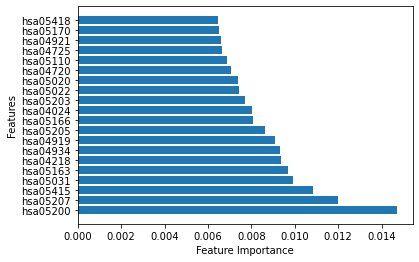

In [275]:
dt_importance=pd.DataFrame()
model_final(algorithm, algorithm_name, feature_name,
            x_overtrain, y_overtrain, x_overtest, y_overtest,
            n_estimator, n_depth, n_split, n_leaf)

<h1>Run Other Classifier<h1>
    <h2>1.LogisticRegression<h2>

In [274]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0)
lr.fit(x_overtrain, y_overtrain)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

prediction = lr.predict(x_overtest)
print((prediction == y_overtest).mean())

0.6517089049058359


/home/dmk/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<h2>2. SGD classifier<h2>

from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(random_state=0)
sgd.fit(x_overtrain, y_overtrain)
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
prediction = sgd.predict(x_overtest)
print((prediction == y_overtest).mean())


<h2>3.K-N Classifier<h2>

In [294]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(x_overtrain, y_overtrain)  
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

prediction = knn.predict(x_overtest)
print((prediction == y_overtest).mean())
knn2 = KNeighborsClassifier(n_neighbors=9)
knn2.fit(x_overtrain2, y_overtrain2)  
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

prediction = knn2.predict(x_overtest2)
print((prediction == y_overtest2).mean())

0.659846547314578
0.6567840948726892


<h2>4. Support Vector Classifier<h2>

In [293]:
from sklearn.svm import SVC 
svc = SVC(random_state=0)
svc.fit(x_overtrain2, y_overtrain2)
svc_pred = svc.predict(x_overtest2)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


print((svc_pred == y_overtest2).mean())

0.6309731426578304


In [6]:
pathway=pd.read_csv("ppipathwayreactome.csv",index_col=0)
ada = ADASYN()
x_re= pathway[pathway.columns.difference(['phenotype'])]
y_re= pathway['phenotype']
X_resampled, y_resampled = ada.fit_resample(x_re, y_re)
scaler = StandardScaler()
x_overscaled = scaler.fit_transform(X_resampled)

x_overtrain_re, x_overtest_re, y_overtrain_re, y_overtest_re= train_test_split(x_overscaled, y_resampled, 
                                                            test_size = 0.2, random_state = 123)


NameError: name 'torch' is not defined

In [14]:
train_acc_before, test_acc_before = modeling_uncustomized(algorithm, 
                                                          x_overtrain_re,
                                                          y_overtrain_re,
                                                          x_overtest_re,
                                                          y_overtest_re)

학습 데이터셋 정확도: 0.589
테스트 데이터셋 정확도: 0.581


In [42]:
x_re2=x_re.sum(axis=1)

In [55]:
x_re2

0        3.0
1        0.0
2        1.0
3        0.0
4        0.0
        ... 
33226    0.0
33227    0.0
33228    0.0
33229    0.0
33231    0.0
Length: 8711, dtype: float64

In [61]:
x_re2.loc[33229]

0.0

In [62]:
indexs=[]
for i in x_re2.index:
    print(i)
    if x_re2.loc[i]!=0.0 :
        indexs.append(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
27

In [54]:
x_re

,R-HSA-109582,R-HSA-112316,R-HSA-1266738,R-HSA-1430728,R-HSA-1474165,R-HSA-1474244,R-HSA-1500931,R-HSA-162582,R-HSA-1640170,R-HSA-1643685,...,R-HSA-69306,R-HSA-73894,R-HSA-74160,R-HSA-8953854,R-HSA-8953897,R-HSA-8963743,R-HSA-9609507,R-HSA-9612973,R-HSA-9709957,R-HSA-9748784
0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
x_re=x_re.loc[indexs]

In [64]:
x_re

,R-HSA-109582,R-HSA-112316,R-HSA-1266738,R-HSA-1430728,R-HSA-1474165,R-HSA-1474244,R-HSA-1500931,R-HSA-162582,R-HSA-1640170,R-HSA-1643685,...,R-HSA-69306,R-HSA-73894,R-HSA-74160,R-HSA-8953854,R-HSA-8953897,R-HSA-8963743,R-HSA-9609507,R-HSA-9612973,R-HSA-9709957,R-HSA-9748784
0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
33209,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
y_re2=y_re2.loc[indexs]

In [66]:
y_re.value_counts()

1.0    1446
0.0     100
Name: phenotype, dtype: int64

In [67]:
X_resampled, y_resampled = ada.fit_resample(x_re, y_re)
scaler = StandardScaler()
x_overscaled = scaler.fit_transform(X_resampled)

x_overtrain_re, x_overtest_re, y_overtrain_re, y_overtest_re= train_test_split(x_overscaled, y_resampled, 
                                                            test_size = 0.2, random_state = 123)
train_acc_before, test_acc_before = modeling_uncustomized(algorithm, 
                                                          x_overtrain_re,
                                                          y_overtrain_re,
                                                          x_overtest_re,
                                                          y_overtest_re)

학습 데이터셋 정확도: 0.93
테스트 데이터셋 정확도: 0.867


최종 모델 저장 완료! 파일 경로: model/ASD__diagnosisrfc.pkl

Accuracy: 0.864
Precision: 0.854
Recall: 0.875
F1-score: 0.864
   Feature  Importance
1      NaN       0.066
7      NaN       0.060
12     NaN       0.060
11     NaN       0.059
28     NaN       0.055
14     NaN       0.052
5      NaN       0.050
26     NaN       0.047
3      NaN       0.045
21     NaN       0.044
0      NaN       0.040
17     NaN       0.038
10     NaN       0.038
15     NaN       0.038
6      NaN       0.036
4      NaN       0.033
23     NaN       0.033
18     NaN       0.033
22     NaN       0.031
2      NaN       0.026
13     NaN       0.021
16     NaN       0.019
20     NaN       0.018
27     NaN       0.014
19     NaN       0.014
8      NaN       0.012
9      NaN       0.011
25     NaN       0.003
24     NaN       0.002


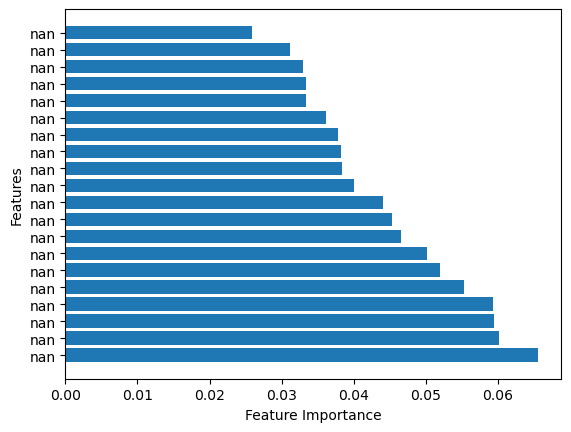

In [76]:
dt_importance=pd.DataFrame()
model_final(algorithm, algorithm_name, '',
            x_overtrain_re, y_overtrain_re, x_overtest_re, y_overtest_re,
            n_estimator, n_depth, n_split, n_leaf)

In [ ]:
X_resampled, y_resampled = ada.fit_resample(x, y)
scaler = StandardScaler()
x_overscaled = scaler.fit_transform(X_resampled)

x_overtrain_re, x_overtest_re, y_overtrain_re, y_overtest_re= train_test_split(x_overscaled, y_resampled, 
                                                            test_size = 0.2, random_state = 123)
train_acc_before, test_acc_before = modeling_uncustomized(algorithm, 
                                                          x_overtrain_re,
                                                          y_overtrain_re,
                                                          x_overtest_re,
                                                          y_overtest_re)

최종 모델 저장 완료! 파일 경로: model/ASD__diagnosisrfc.pkl

Accuracy: 0.801
Precision: 0.898
Recall: 0.671
F1-score: 0.768
    Feature  Importance
309     NaN       0.015
233     NaN       0.013
248     NaN       0.012
128     NaN       0.011
315     NaN       0.011
..      ...         ...
111     NaN       0.000
72      NaN       0.000
35      NaN       0.000
23      NaN       0.000
73      NaN       0.000

[352 rows x 2 columns]


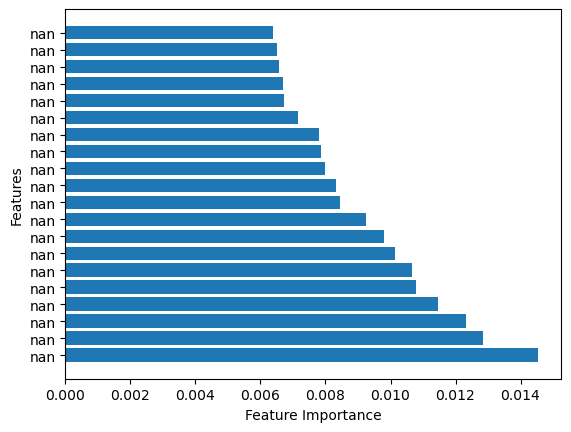

In [79]:
pathway=pd.read_csv('data/ppipathway1.3.csv',index_col=0)
ada = ADASYN()
x = pathway[pathway.columns.difference(['phenotype'])]
y = pathway['phenotype']
X_resampled, y_resampled = ada.fit_resample(x, y)
scaler = StandardScaler()
x_overscaled_kegg = scaler.fit_transform(X_resampled)
x_overtrain, x_overtest, y_overtrain, y_overtest = train_test_split(x_overscaled_kegg, y_resampled, 
                                                    test_size = 0.2, random_state = 123)
dt_importance=pd.DataFrame()
model_final(algorithm, algorithm_name, '',
            x_overtrain, y_overtrain, x_overtest, y_overtest,
            n_estimator, n_depth, n_split, n_leaf)